In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def hex_to_bin(hex_num):
    
    binary_value = bin(int(str(hex_num), 16))[2:]
    
    return binary_value

def int_to_bin(int_num):
    
    binary_value = bin(int_num)[2:]
    
    return binary_value

hex_to_dec = lambda x: float(int(x, 16))

dec_to_hex = lambda x : hex(int(x))[2:]

In [36]:
benign_data = pd.read_csv('../data/Car Hacking Dataset/benign_data.csv')
smart_attack = pd.read_csv('../data/Car Hacking Dataset/smart_output.csv')

In [4]:
benign_data['ID'] = benign_data['ID'].apply(hex_to_dec)
benign_data['Payload'] = benign_data['Payload'].apply(hex_to_dec)
benign_data.head()

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,848.0,8,3.716925e+17,0
1,1.479121e+09,704.0,8,1.441152e+18,0
2,1.479121e+09,1072.0,8,0.000000e+00,0
3,1.479121e+09,1201.0,8,0.000000e+00,0
4,1.479121e+09,497.0,8,0.000000e+00,0


In [5]:
benign_data['label'].value_counts()

0    988871
Name: label, dtype: int64

In [6]:
smart_attack.head()

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,848.0,8.0,3.716925e+17,0.0
1,1.479121e+09,704.0,8.0,1.441152e+18,0.0
2,1.479121e+09,1072.0,8.0,0.000000e+00,0.0
3,1.479121e+09,1201.0,8.0,0.000000e+00,0.0
4,1.479121e+09,497.0,8.0,0.000000e+00,0.0


In [7]:
smart_attack['label'].value_counts()

0.0    988871
1.0     31168
Name: label, dtype: int64

In [8]:
def calculate_periodicity(df):
    # Initialize an empty dictionary to store the periodicity for each can_id
    periodicity_dict = {}

    # Group the DataFrame by 'can_id'
    grouped = df.groupby('ID')

    for can_id, group_df in grouped:
        # Sort the DataFrame by 'timestamp'
        sorted_df = group_df.sort_values(by='Timestamp')

        # Calculate the periodicity for the current can_id
        first_timestamp = sorted_df.iloc[0]['Timestamp']
        last_timestamp = sorted_df.iloc[-1]['Timestamp']
        num_occurrences = len(sorted_df)

        if num_occurrences > 1:
            periodicity = (last_timestamp - first_timestamp) / (num_occurrences - 1)
        else:
            periodicity = 0  # Avoid division by zero if there's only one occurrence

        # Store the periodicity in the dictionary
        periodicity_dict[can_id] = periodicity

    return periodicity_dict

In [9]:
benign_periodicity = calculate_periodicity(benign_data)
smart_periodicity = calculate_periodicity(smart_attack)

In [45]:
smart_attack

,Timestamp,ID,DLC,Payload,label
0,2016-11-14 11:03:54.850202112,848.0,8.0,3.716925e+17,0.0
1,2016-11-14 11:03:54.850423040,704.0,8.0,1.441152e+18,0.0
2,2016-11-14 11:03:54.850977024,1072.0,8.0,0.000000e+00,0.0
3,2016-11-14 11:03:54.851214848,1201.0,8.0,0.000000e+00,0.0
4,2016-11-14 11:03:54.851463168,497.0,8.0,0.000000e+00,0.0
...,...,...,...,...,...
1020034,2016-11-14 11:12:21.283899904,688.0,5.0,7.388190e+11,0.0
1020035,2016-11-14 11:12:21.286086912,790.0,8.0,3.760682e+17,0.0
1020036,2016-11-14 11:12:21.286309888,399.0,8.0,1.831642e+19,0.0
1020037,2016-11-14 11:12:21.286533120,608.0,8.0,3.618705e+18,0.0


In [10]:
arb_ids = list(benign_periodicity.keys())

benign_periodicity_values = [benign_periodicity[can_id] for can_id in arb_ids]
smart_periodicity_values = [smart_periodicity[can_id] for can_id in arb_ids]

periodicity_df = pd.DataFrame(columns = 
                              ['ID', 'Benign Periodicity', 'Smart Periodicity'],
                              data = {'ID': arb_ids,
                                      'Benign Periodicity': benign_periodicity_values,
                                      'Smart Periodicity': smart_periodicity_values})

periodicity_df['Delta'] = abs(periodicity_df['Benign Periodicity'] - periodicity_df['Smart Periodicity'])

periodicity_df = periodicity_df.sort_values(by='Delta', ascending=False)

periodicity_df['ID'] = periodicity_df['ID'].apply(dec_to_hex)

periodicity_df.head()

,ID,Benign Periodicity,Smart Periodicity,Delta
23,5a0,0.999115,0.032620,0.966494
24,5a2,0.999114,0.109309,0.889806
1,a0,0.099916,0.055225,0.044692
26,690,0.099999,0.055784,0.044215
2,a1,0.099916,0.056190,0.043726


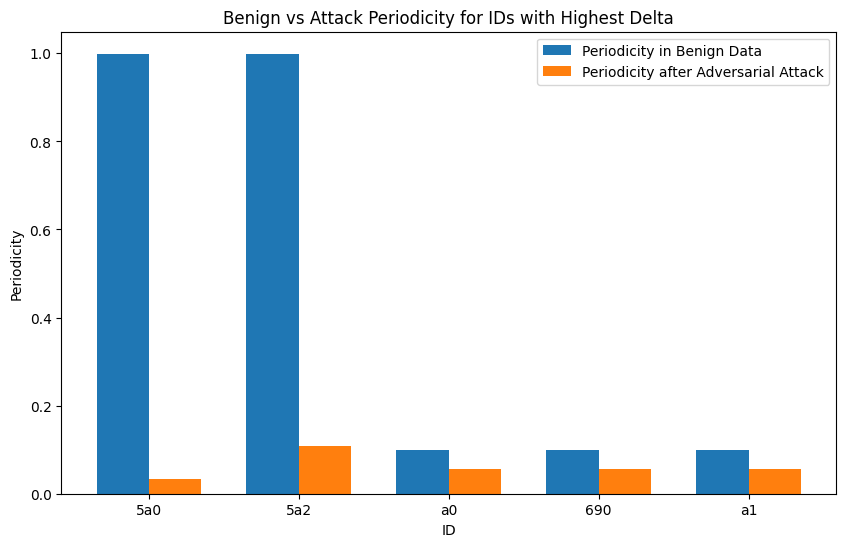

In [17]:
top_5_delta_ids = periodicity_df.head(5)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions = range(len(top_5_delta_ids))

benign_bars = ax.bar(bar_positions, top_5_delta_ids['Benign Periodicity'], bar_width, label='Periodicity in Benign Data')
smart_bars = ax.bar([p + bar_width for p in bar_positions], top_5_delta_ids['Smart Periodicity'], bar_width, label='Periodicity after Adversarial Attack')

ax.set_xticks([p + bar_width / 2 for p in bar_positions])
ax.set_xticklabels(top_5_delta_ids['ID'])

ax.set_xlabel('ID')
ax.set_ylabel('Periodicity')
ax.set_title('Benign vs Attack Periodicity for IDs with Highest Delta')
ax.legend()

plt.show()


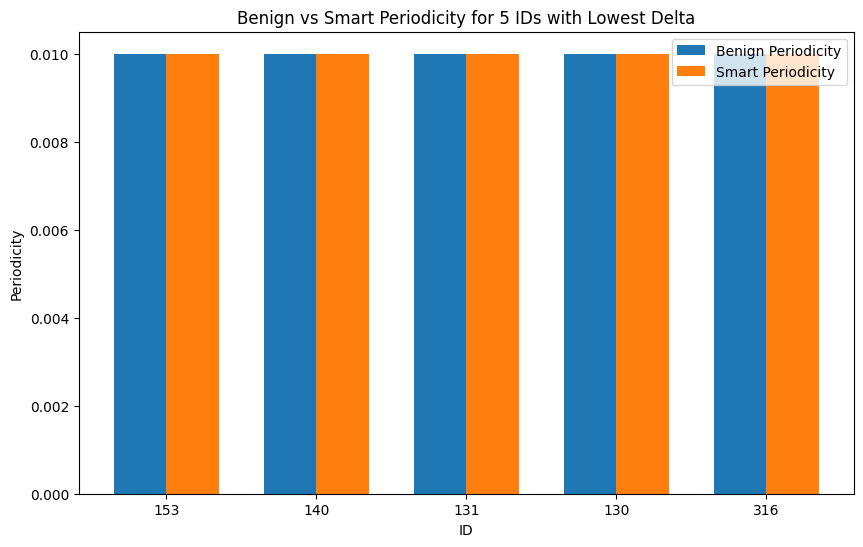

In [12]:
bottom_5_delta_ids = periodicity_df.tail(5)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions = range(len(top_5_delta_ids))

benign_bars = ax.bar(bar_positions, bottom_5_delta_ids['Benign Periodicity'], bar_width, label='Benign Periodicity')
smart_bars = ax.bar([p + bar_width for p in bar_positions], bottom_5_delta_ids['Smart Periodicity'], bar_width, label='Smart Periodicity')

ax.set_xticks([p + bar_width / 2 for p in bar_positions])
ax.set_xticklabels(bottom_5_delta_ids['ID'])

ax.set_xlabel('ID')
ax.set_ylabel('Periodicity')
ax.set_title('Benign vs Smart Periodicity for 5 IDs with Lowest Delta')
ax.legend()

plt.show()


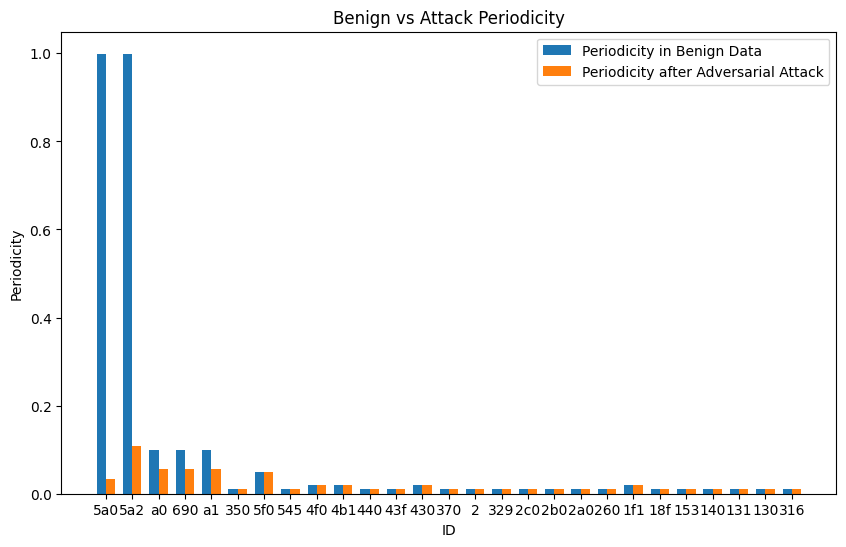

In [46]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions = range(len(periodicity_df))

benign_bars = ax.bar(bar_positions, periodicity_df['Benign Periodicity'], bar_width, label='Periodicity in Benign Data')
smart_bars = ax.bar([p + bar_width for p in bar_positions], periodicity_df['Smart Periodicity'], bar_width, label='Periodicity after Adversarial Attack')

ax.set_xticks([p + bar_width / 2 for p in bar_positions])
ax.set_xticklabels(periodicity_df['ID'])

ax.set_xlabel('ID')
ax.set_ylabel('Periodicity')
ax.set_title('Benign vs Attack Periodicity')
ax.legend()

plt.show()


<AxesSubplot: >

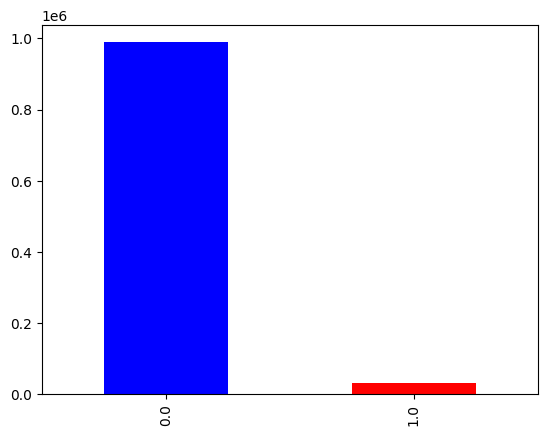

In [24]:
smart_attack['label'].value_counts().plot(kind='bar', color=['blue', 'red'])

In [14]:
# benign_data['Timestamp'] = pd.to_datetime(benign_data['Timestamp'])

# # Calculate the number of bits transmitted for each message
# # Assuming that each byte in the 'Payload' column is 8 bits
# benign_data['Bits'] = benign_data['DLC'] * 8

# # Calculate the time difference between consecutive timestamps
# benign_data['TimeDiff'] = benign_data['Timestamp'].diff()

# # Calculate the Busrate (bits per second)
# benign_data['Busrate'] = benign_data['Bits'] / benign_data['TimeDiff'].dt.total_seconds()

# # Resample the data at 1-second intervals and sum the bits transmitted in each second
# busrate_per_second = benign_data.resample('1S', on='Timestamp').sum()['Busrate']

# # Plot the Busrate
# plt.plot(busrate_per_second.index, busrate_per_second.values)
# plt.xlabel('Time')
# plt.ylabel('Busrate (bits per second)')
# plt.title('Busrate Plot')
# plt.show()

In [15]:
from datetime import datetime


dt_object = datetime.fromtimestamp(benign_data['Timestamp'].iloc[0])
# Print the datetime object with nanoseconds

# If you want to include nanoseconds in the output, you can use strftime
formatted_time = dt_object.strftime('%Y-%m-%d %H:%M:%S.%f')

print(formatted_time)

2016-11-14 16:33:54.850202


In [16]:
dt_object = datetime.fromtimestamp(benign_data['Timestamp'].iloc[1])
# Print the datetime object with nanoseconds

# If you want to include nanoseconds in the output, you can use strftime
formatted_time = dt_object.strftime('%Y-%m-%d %H:%M:%S.%f')

print(formatted_time)

2016-11-14 16:33:54.850423


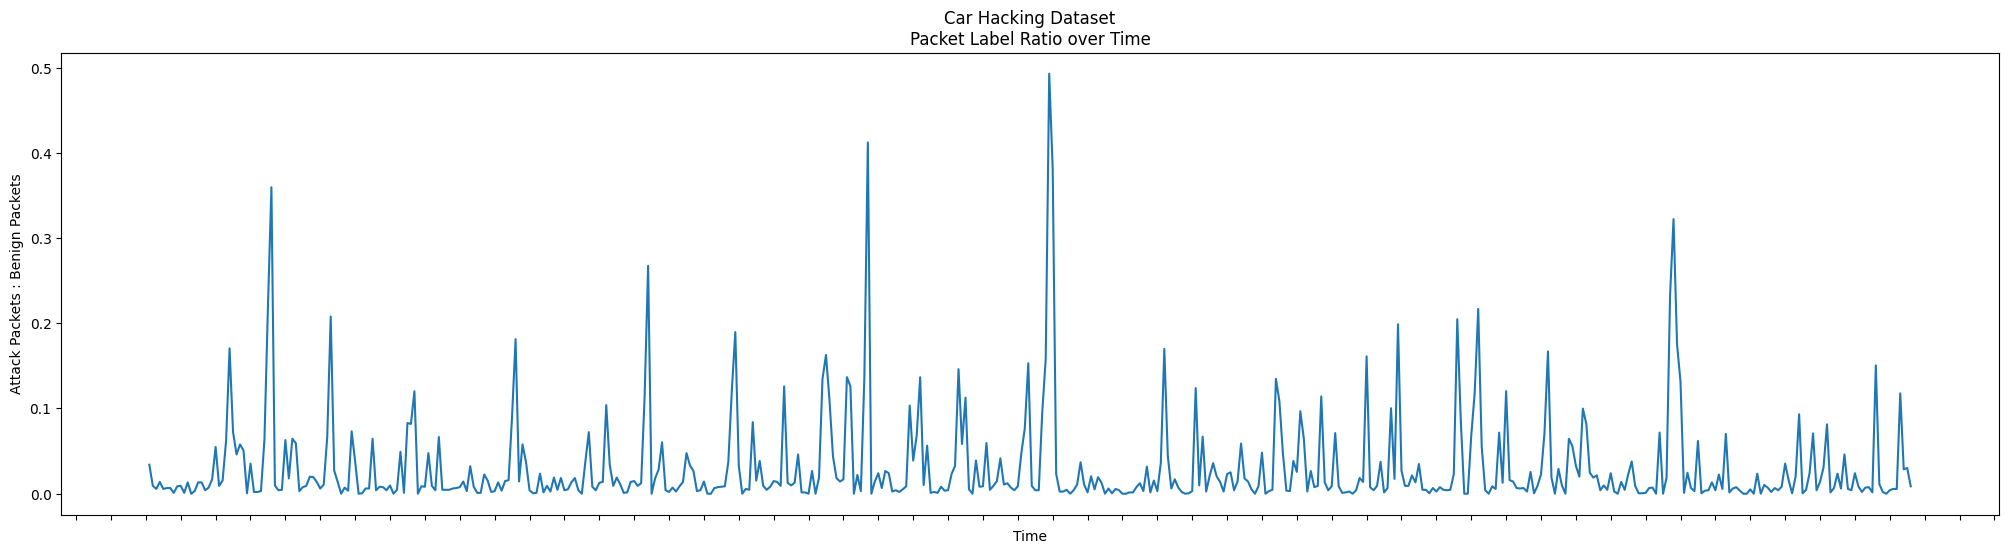

In [37]:
import matplotlib.dates as mdates

# Assuming 'smart_attack' is your DataFrame
# Assuming 'Timestamp' is the column with timestamps in seconds
# Assuming 'label' is the binary label column

# Convert 'Timestamp' to datetime format
smart_attack['Timestamp'] = pd.to_datetime(smart_attack['Timestamp'], unit='s')

# Resample data into 10-second intervals
dos_ch_resampled = smart_attack.resample('1S', on='Timestamp').count()

# Calculate the ratio of label 1 to label 0
label_1_count = smart_attack[smart_attack['label'] == 1].resample('1S', on='Timestamp').count()['label']
label_0_count = smart_attack[smart_attack['label'] == 0].resample('1S', on='Timestamp').count()['label']
dos_ch_resampled['label_ratio'] = label_1_count / label_0_count

plt.figure(figsize=(25, 6))

# Plot the ratio
plt.plot(dos_ch_resampled.index, dos_ch_resampled['label_ratio'])
plt.xlabel('Time')
plt.ylabel('Attack Packets : Benign Packets')
plt.title('Car Hacking Dataset\nPacket Label Ratio over Time')

# Format x-axis timestamps as HH:MM:SS
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S')
plt.gca().set_xticklabels([])
plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=10))

plt.show()


In [29]:
benign_data['Timestamp'].iloc[0]

1479121434.850202

In [31]:
smart_attack['Timestamp'].iloc[-1]

1479121941.286773

In [39]:
smart_attack['label'].value_counts()

0.0    988871
1.0     31168
Name: label, dtype: int64

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import argparse
from joblib import dump
import matplotlib.pyplot as plt


parser = argparse.ArgumentParser()

parser.add_argument('directory', 
                    type=str, 
                    help = 'directory where files are stored')

parser.add_argument('file_name',
                    type = str,
                    help = 'dos traffic file')


args = parser.parse_args()


base_dir = args.directory
data_path = os.path.join(base_dir, args.file_name)
save_loc = os.path.join(base_dir, 'Traditional DoS Training and Testing')
os.makedirs(save_loc, exist_ok = True)
data = pd.read_csv(data_path)

data.drop(['Timestamp'], axis = 1, inplace=True)

def hex_to_bin(hex_num):
    
    binary_value = bin(int(str(hex_num), 16))[2:]
    
    return binary_value

def int_to_bin(int_num):
    
    binary_value = bin(int_num)[2:]
    
    return binary_value

def pad(value, length):
    
    curr_length = len(str(value))
    
    zeros = '0' * (length - curr_length)
    
    return zeros + value

hex_to_dec = lambda x: int(x, 16)

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

def sequencify_data(X, y, seq_size=10):
    max_index = len(X) - seq_size + 1

    X_seq = []
    y_seq = []

    for i in range(0, max_index, seq_size):
        X_seq.append(X[i:i+seq_size])  # Append the sequence from DataFrame 'X'
        y_seq.append(1 if 1 in y[i:i+seq_size] else 0)  # Check for '1' in 'y' values

    return np.array(X_seq), np.array(y_seq)

data = transform_data(data)

X = data.drop('label', axis = 1)
y = data['label']

X_seq, y_seq = sequencify_data(X.values, y.values)

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X_seq, y_seq, test_size = 0.2, shuffle= True)

#Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dump(scaler, os.path.join(save_loc, 'scaler.joblib'))

seq_scaler = StandardScaler()
num_train_samples, seq_length, num_features = X_seq_train.shape
num_test_samples, _, _ = X_seq_test.shape

X_train_seq_reshaped = X_seq_train.reshape(num_train_samples, -1)
X_test_seq_reshaped = X_seq_test.reshape(num_test_samples, -1)

X_train_seq_scaled = seq_scaler.fit_transform(X_train_seq_reshaped)
X_test_seq_scaled = seq_scaler.transform(X_test_seq_reshaped)

dump(seq_scaler, os.path.join(save_loc, 'seq_scaler.joblib'))

# Reshape the scaled data back to the original shape
X_seq_train = X_train_seq_scaled.reshape(num_train_samples, seq_length, num_features)
X_seq_test = X_test_seq_scaled.reshape(num_test_samples, seq_length, num_features)

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train) 

##Models

print("-----MLP-------")

mlp = Sequential()
mlp.add(Input(shape = (4)))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(1, activation = 'sigmoid'))

mlp.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

mlp_hist = mlp.fit(X_train_smote, y_train_smote, epochs=100, callbacks = [es], validation_split=0.2, batch_size = 128)

##MLP
print("-----MLP-------")

threshold = 0.5
mlp_preds = mlp.predict(X_test)
mlp_preds = (mlp_preds >= threshold).astype(int)

print("ACCURACY: ", accuracy_score(y_test, mlp_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, mlp_preds))

with open(os.path.join(save_loc,'evaluation_results.txt'),'w') as file:
    file.write("-------MLP-------\n")
    file.write(f"Accuracy Score: ")
    file.write(str(accuracy_score(y_test, mlp_preds)))
    file.write("\n")
    file.write('Classification Report:\n')
    file.write(str(classification_report(y_test, mlp_preds)))
    file.write("\n\n\n\n")

mlp.save(os.path.join(save_loc, 'mlp.h5'))

plt.figure(figsize=(10, 10))
plt.plot(mlp_hist.history['loss'])
plt.plot(mlp_hist.history['val_loss'])
plt.title('MLP Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(os.path.join(save_loc,'mlp_training_history.png'))

##LSTM

print("-----LSTM-------")

lstm = Sequential()

lstm.add(Input(shape = X_seq_train.shape[1:]))
lstm.add(LSTM(128, activation = 'relu'))
lstm.add(Dense(1, activation = 'sigmoid'))

lstm.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

lstm_hist = lstm.fit(X_seq_train, y_seq_train, batch_size = 128, validation_split = 0.2,
        callbacks = [es], epochs = 1000)

print("-----LSTM-------")

lstm_preds = lstm.predict(X_seq_test, batch_size=4096)
lstm_preds = (lstm_preds >= threshold).astype(int)

print("ACCURACY: ", accuracy_score(y_seq_test, lstm_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_seq_test, lstm_preds))

with open(os.path.join(save_loc,'evaluation_results.txt'),'a') as file:
    file.write("-------LSTM-------\n")
    file.write(f"Accuracy Score: ")
    file.write(str(accuracy_score(y_seq_test, lstm_preds)))
    file.write("\n")
    file.write('Classification Report:\n')
    file.write(str(classification_report(y_seq_test, lstm_preds)))
    file.write("\n\n\n\n")

lstm.save(os.path.join(save_loc, 'lstm.h5'))

plt.figure(figsize=(10, 10))
plt.plot(lstm_hist.history['loss'])
plt.plot(lstm_hist.history['val_loss'])
plt.title('LSTM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(os.path.join(save_loc,'lstm_training_history.png'))


## XGBOOST
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)
xgb_preds = xgb.predict(X_test)

print("-------XGBOOST-------")
print("ACCURACY: ", accuracy_score(y_test, xgb_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, xgb_preds))
xgb.save_model(os.path.join(save_loc, 'xgb.json'))

with open(os.path.join(save_loc,'evaluation_results.txt'),'a') as file:
    file.write("-------XGB-------\n")
    file.write(f"Accuracy Score: ")
    file.write(str(accuracy_score(y_test, xgb_preds)))
    file.write("\n")
    file.write('Classification Report:\n')
    file.write(str(classification_report(y_test, xgb_preds)))
    file.write("\n\n\n\n")

## DECISION TREE
dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(X_train_smote, y_train_smote)
dt_preds = dt.predict(X_test)

print("-------DECISION TREE--------")
print("ACCURACY: ", accuracy_score(y_test, dt_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, dt_preds))
dump(dt, os.path.join(save_loc, 'dt.pkl'))

with open(os.path.join(save_loc,'evaluation_results.txt'),'a') as file:
    file.write("-------Decision Tree-------\n")
    file.write(f"Accuracy Score: ")
    file.write(str(accuracy_score(y_test, dt_preds)))
    file.write("\n")
    file.write('Classification Report:\n')
    file.write(str(classification_report(y_test, dt_preds)))
    file.write("\n\n\n\n")

## RANDOM FOREST

rf = RandomForestClassifier(n_estimators=100, max_depth=4)
rf.fit(X_train_smote, y_train_smote)
rf_preds = rf.predict(X_test)

print("-------RANDOM FOREST-------\n")
print("ACCURACY: ", accuracy_score(y_test, rf_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, rf_preds))
dump(rf, os.path.join(save_loc, 'rf.pkl'))

with open(os.path.join(save_loc,'evaluation_results.txt'),'a') as file:
    file.write("-------Random Forest-------")
    file.write(f"Accuracy Score: ")
    file.write(str(accuracy_score(y_test, rf_preds)))
    file.write("\n")
    file.write('Classification Report:\n')
    file.write(str(classification_report(y_test, rf_preds)))
    file.write("\n\n\n\n")